## Global To Dos:
* read paper
* [steps document](https://docs.google.com/document/d/1du2fcmVzTqnW0FWGmUxvpR2t6QEfwxDIrHSZs9k3HZM/edit?usp=sharing)

Section 1: Load and Preprocess Data

In [188]:
import utils_preprocessing as up
import utils as ut
import importlib
importlib.reload(ut)
importlib.reload(up)
from itertools import groupby
import yaml
import os
import textdistance
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

## Pre-processing 

Read in YAML and make PATH

In [164]:
#with open("config.yml", 'r') as ymlfile:
#    cfg = yaml.load(ymlfile)

#PATH = os.path.join(cfg['data']['Directory'] + ":" + os.sep, cfg['data']['Folder1'], cfg['data']['Folder2'], cfg['data']['Folder3']) # Alix Path

PATH = 'SOTU/'
#PATH = '/Users/aleistermontfort/Desktop/speeches' # Aleister Path
filetype = '*txt'

Read in Data

In [165]:
speeches, numpar = up.reading_data(PATH,'*.txt')

Create Noun Phrases

In [166]:
new_speeches = up.chunks(speeches, "regex")

Clean Words & Lemmatize Noun Phrases: Spacy - Skip if used Regex Above

In [167]:
clean_speeches = up.clean_words(new_speeches)

In [168]:
words_changed = up.word_changes(new_speeches, 0.5, 100)

In [169]:
phrases_lemmed = up.lemmed_phrases(words_changed, clean_speeches)

Lemmatize Noun Phrases: Regex - Skip if Used Regex Above

In [6]:
#phrases_lemmed = up.lemmed_phrases(words_changed, new_speeches)

Counting Occurrence of Terms

In [170]:
counted_words = up.count_words(phrases_lemmed)

Limit List to Top 1000

In [171]:
top_words = up.top_x(counted_words, 1000)

limit paragraph phrases only to those in top 1000

In [172]:
limited_paragraphs = up.limit(phrases_lemmed, top_words)

## Periodization

In [173]:
tfidfs = up.corpus_tfidf(limited_paragraphs, counted_words, top_words)

In [174]:
periods, dissimilarity = up.periodization(tfidfs)

In [175]:
import operator
sorted_x = sorted(periods.items(), key=operator.itemgetter(1))
years = dissimilarity.index

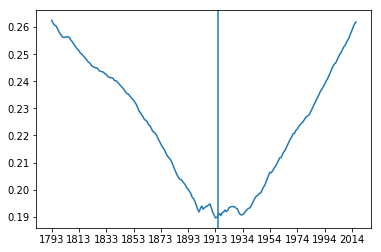

In [176]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker

lists = sorted(periods.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.axvline(pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0]), 0,1)
plt.plot(x, y)
plt.show()

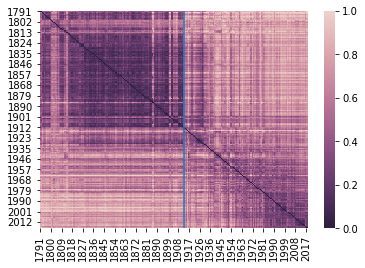

In [177]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
ax = sns.heatmap(dissimilarity, cmap=cmap)
plt.axvline((pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0])), 0,1)
plt.show()

### Before

Before Years

In [178]:

before_1914 = years[:pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0])]
before_dict = {k: v for k, v in limited_paragraphs.items() if k[1] in before_1914}

Before TFIDF

In [179]:
before_tfidfs = up.corpus_tfidf(before_dict, counted_words, top_words)

In [180]:
before_periods, before_dissimilarity = up.periodization(before_tfidfs)

### After

After Years

In [181]:
after_1914 = years[pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0]):]
after_dict = {k: v for k, v in limited_paragraphs.items() if k[1] in after_1914}

After TFIDF

In [182]:
after_tfidfs = up.corpus_tfidf(after_dict, counted_words, top_words)

In [183]:
after_periods, after_dissimilarity = up.periodization(after_tfidfs)

In [184]:
new_periods = {**before_periods, **after_periods}

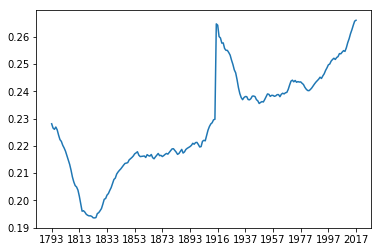

In [185]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker

lists = sorted(new_periods.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

plt.plot(x, y)
plt.show()

## Co-Occurrence Matrix and Dissimilarity Topic Modeling

Build the co-occurrence matrix

In [31]:
pre_occur = ut.convert_dict_to_list(limited_paragraphs)

In [32]:
co_occur = ut.co_oc_matrix(pre_occur, True, True)

Do a cosine similarity

In [33]:
co_matrix = ut.pairwise_similarity(co_occur, 'cosine')

Do a paper dissimilarity

In [34]:
co_matrix_paper = ut.pairwise_similarity(co_occur, 'paper')

## I'm reading in from a csv to save time

In [197]:
co_matrix = pd.read_csv('regex_cosine.csv', index_col = 0)
co_matrix_paper = pd.read_csv('regex_paper.csv', index_col = 0)

### Global Corpus

For the next section, if you're working on regex then include 'regex' in the parameters of the network graphing function. If you're working off spacy, include 'spacy' in the parameters of the network graphing function

In [158]:
nounphrase = 'regex'
#nounphrase = 'spacy'

Create network graph using community detection algorithms and paper's approach

['mr', 'president', 'member', 'congress', 'honor', 'today', 'mark', 'union', 'address', 'old', 'republic', 'washington', 'begin', 'nation', 'preservation', 'liberty', 'finally', 'hand', 'the american people', 'friend', 'press', 'place', 'let', 'say', 'matter', 'ask', 'stand', 'together', 'aggression', 'speak', 'day', 'arm', 'make', 'country', 'serve', 'well', 'u', 'peace', 'purchase', 'price', 'strength', 'burden', 'freedom', 'visit', 'chamber', 'last year', 'believe', 'fail', 'propose', 'administration', 'state', 'america', 'could', 'achieve', 'prosperity', 'world', 'child', 'humanity', 'duty', 'report', 'tonight', 'progress', 'relation', 'other nation', 'foundation', 'lay', 'change', 'face', 'people', 'high', 'difference', 'line', 'million', 'harbor', 'safe', 'understand', 'must', 'look', 'go', 'situation', 'time', 'see', 'increase', 'inflation', 'soon', 'turn', 'government', 'money', 'supply', 'spending', 'last', 'month', 'example', 'percent', 'remain', 'interest', 'rate', 'reach', 

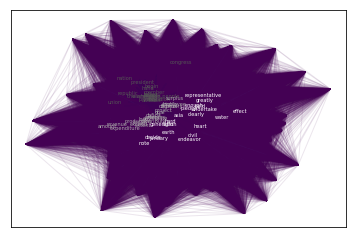

In [198]:
global_cda_paper = ut.network_graph(co_matrix_paper, 'community', nounphrase, 'global', 'paper')

Create network graph using community detection algorithms and cosine similarity

['mr', 'president', 'member', 'congress', 'mark', 'union', 'address', 'republic', 'washington', 'preservation', 'press', 'place', 'matter', 'arm', 'make', 'country', 'visit', 'fail', 'propose', 'state', 'could', 'humanity', 'duty', 'relation', 'lay', 'difference', 'line', 'harbor', 'time', 'soon', 'government', 'remain', 'interest', 'however', 'call', 'december', 'act', 'would', 'far', 'decline', 'wrong', 'since', 'power', 'return', 'federal', 'independence', 'restore', 'new', 'suffer', 'upon', 'whatever', 'preserve', 'road', 'course', 'question', 'two', 'remove', 'maintain', 'offer', 'policy', 'pas', 'degree', 'highly', 'point', 'require', 'law', 'control', 'yet', 'without', 'find', 'urge', 'extent', 'occur', 'anticipate', 'submit', 'february', 'th', 'may', 'worthy', 'refer', 'committee', 'whose', 'august', 'sign', 'the same time', 'receive', 'message', 'intend', 'long', 'recommend', 'affect', 'result', 'citizen', 'feel', 'right', 'jurisdiction', 'answer', 'hold', 'neither', 'properly

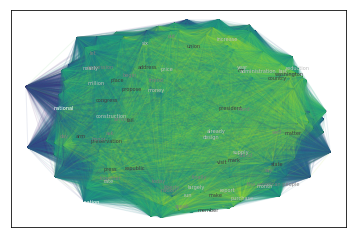

In [199]:
global_cda_cosine = ut.network_graph(co_matrix, 'community', nounphrase, 'global', 'cosine')

Create network graph using kmeans unsupervised clustering and paper's approach 

In [200]:
co_matrix_paper = pd.read_csv('regex_paper.csv', index_col = 0)

['mr', 'president', 'member', 'congress', 'honor', 'today', 'mark', 'union', 'address', 'old', 'republic', 'washington', 'begin', 'nation', 'preservation', 'liberty', 'finally', 'hand', 'the american people', 'friend', 'press', 'place', 'let', 'say', 'matter', 'ask', 'stand', 'together', 'aggression', 'speak', 'arm', 'serve', 'well', 'purchase', 'price', 'strength', 'burden', 'visit', 'chamber', 'last year', 'fail', 'propose', 'administration', 'achieve', 'prosperity', 'child', 'humanity', 'duty', 'report', 'progress', 'relation', 'other nation', 'foundation', 'lay', 'change', 'face', 'high', 'difference', 'line', 'million', 'harbor', 'safe', 'understand', 'look', 'go', 'situation', 'inflation', 'soon', 'turn', 'money', 'supply', 'spending', 'last', 'month', 'example', 'percent', 'interest', 'rate', 'largely', 'industry', 'construction', 'already', 'however', 'past', 'reduction', 'cut', 'nearly', 'half', 'design', 'economy', 'job', 'low', 'december', 'run', 'tax', 'faith', 'steadily', 

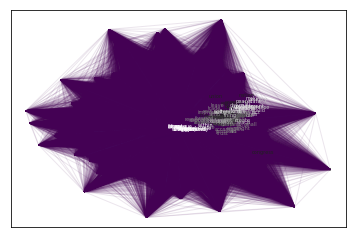

In [201]:
global_kmeans_paper = ut.network_graph(co_matrix_paper, 'kmeans', nounphrase, 'global', 'paper')

Create network graph using kmeans unsupervised clustering and cosine similarity 

['president', 'congress', 'mark', 'union', 'address', 'washington', 'preservation', 'visit', 'humanity', 'duty', 'relation', 'line', 'soon', 'government', 'last', 'act', 'decline', 'wrong', 'federal', 'road', 'question', 'two', 'pas', 'extent', 'occur', 'anticipate', 'submit', 'department', 'worthy', 'refer', 'receive', 'message', 'recommend', 'operation', 'citizen', 'answer', 'properly', 'grant', 'recently', 'period', 'assume', 'apply', 'belong', 'enterprise', 'might', 'perform', 'land', 'view', 'subject', 'south', 'attempt', 'event', 'announce', 'protection', 'observe', 'great', 'rule', 'declare', 'water', 'continent', 'decide', 'occupy', 'due', 'company', 'fix', 'remedy', 'proceed', 'regulation', 'opinion', 'property', 'regulate', 'exercise', 'confer', 'name', 'proper', 'delay', 'arise', 'connection', 'execute', 'organization', 'commerce', 'operate', 'earnestly', 'consideration', 'provision', 'heretofore', 'direct', 'exclude', 'adopt', 'pending', 'application', 'executive', 'commiss

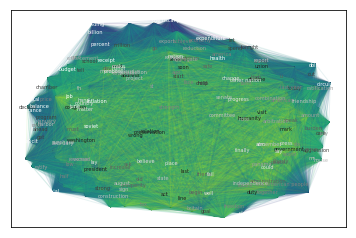

In [202]:
global_kmeans_cosine= ut.network_graph(co_matrix, 'kmeans', nounphrase, 'global', 'cosine')

### Before 1914 Corpus

First turn the before dictionary into a co-occurrence matrix and create cosine and dissimilarity versions of it

In [186]:
before_occur = ut.convert_dict_to_list(before_dict)
co_before = ut.co_oc_matrix(before_occur, True, False)
before_cosine = ut.pairwise_similarity(co_before, 'cosine')
before_paper = ut.pairwise_similarity(co_before, 'paper')

In [187]:
before_paper.to_csv('before_regex.csv')
before_cosine.to_csv('before_cosine.csv')

Create network graph using community detection algorithm and paper dissimilarity

['senate', 'house', 'representative', 'still', 'continue', 'period', 'prosperity', 'law', 'work', 'create', 'condition', 'make', 'possible', 'would', 'easy', 'enough', 'destroy', 'advance', 'nation', 'continent', 'two', 'men', 'sense', 'among', 'old', 'world', 'energy', 'find', 'place', 'success', 'people', 'upon', 'future', 'even', 'large', 'past', 'event', 'last', 'four', 'year', 'decide', 'must', 'great', 'may', 'either', 'fall', 'greatly', 'succeed', 'avoid', 'endeavor', 'come', 'try', 'follow', 'civil', 'war', 'present', 'face', 'heart', 'hope', 'struggle', 'u', 'problem', 'abroad', 'home', 'know', 'well', 'provide', 'bring', 'head', 'show', 'day', 'washington', 'government', 'preserve', 'country', 'ever', 'occupy', 'material', 'due', 'century', 'sustain', 'high', 'take', 'lead', 'evil', 'action', 'benefit', 'community', 'whole', 'never', 'yet', 'aggregate', 'small', 'indeed', 'compare', 'wealth', 'good', 'insurance', 'company', 'especially', 'capital', 'save', 'bank', 'farm', 'hi

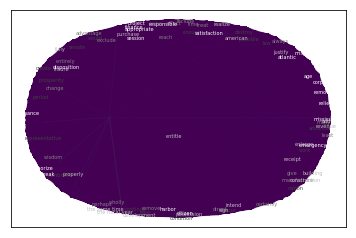

In [189]:
before_cda_paper = ut.network_graph(before_paper, 'community', nounphrase, 'before', 'paper')

Create network graph using community detection algorithm and cosine dissimilarity

['senate', 'house', 'representative', 'still', 'continue', 'law', 'make', 'would', 'continent', 'two', 'sense', 'place', 'upon', 'event', 'decide', 'great', 'may', 'either', 'succeed', 'follow', 'civil', 'war', 'hope', 'struggle', 'know', 'bring', 'washington', 'government', 'preserve', 'country', 'occupy', 'century', 'sustain', 'take', 'lead', 'action', 'insurance', 'company', 'favor', 'also', 'progress', 'side', 'fail', 'shall', 'proceed', 'hold', 'message', 'question', 'step', 'propose', 'power', 'act', 'property', 'right', 'exercise', 'confer', 'name', 'obtain', 'state', 'determine', 'proper', 'become', 'abandon', 'international', 'result', 'without', 'delay', 'exist', 'attempt', 'revolution', 'congress', 'arise', 'connection', 'constitution', 'execute', 'statute', 'within', 'commerce', 'directly', 'engage', 'earnestly', 'subject', 'consideration', 'view', 'provision', 'finally', 'doubt', 'prove', 'purpose', 'set', 'heretofore', 'justice', 'enforcement', 'could', 'proposition', 're

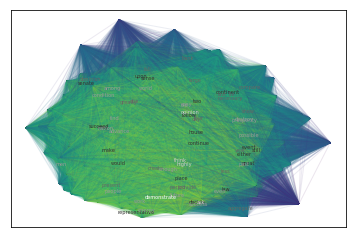

In [190]:
before_cda_cosine = ut.network_graph(before_cosine, 'community', nounphrase, 'before', 'cosine')

Create network graph using kmeans and paper dissimilarity

In [194]:
before_paper = pd.read_csv('before_regex.csv', index_col =0)

['senate', 'house', 'representative', 'still', 'continue', 'period', 'prosperity', 'law', 'work', 'create', 'condition', 'make', 'possible', 'would', 'easy', 'enough', 'destroy', 'advance', 'nation', 'continent', 'two', 'men', 'sense', 'among', 'old', 'world', 'energy', 'find', 'place', 'success', 'people', 'upon', 'future', 'even', 'large', 'past', 'event', 'last', 'four', 'year', 'decide', 'must', 'great', 'may', 'either', 'fall', 'greatly', 'succeed', 'avoid', 'endeavor', 'come', 'try', 'follow', 'civil', 'war', 'present', 'face', 'heart', 'hope', 'struggle', 'u', 'problem', 'abroad', 'home', 'know', 'well', 'provide', 'bring', 'head', 'show', 'day', 'washington', 'government', 'preserve', 'country', 'ever', 'occupy', 'material', 'due', 'century', 'sustain', 'high', 'take', 'lead', 'evil', 'action', 'benefit', 'community', 'whole', 'never', 'yet', 'aggregate', 'small', 'indeed', 'compare', 'wealth', 'good', 'insurance', 'company', 'especially', 'capital', 'save', 'bank', 'farm', 'hi

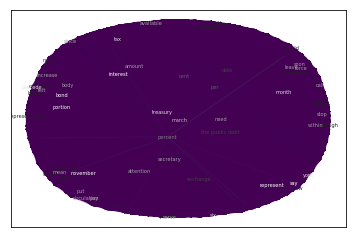

In [195]:
before_kmeans_paper = ut.network_graph(before_paper, 'kmeans', nounphrase, 'before', 'paper')

Create network graph using kmeans and cosine similarity

['prosperity', 'work', 'easy', 'enough', 'destroy', 'men', 'old', 'energy', 'future', 'four', 'fall', 'succeed', 'try', 'face', 'abroad', 'home', 'head', 'show', 'material', 'high', 'evil', 'community', 'small', 'good', 'capital', 'save', 'history', 'keep', 'check', 'remedy', 'regulation', 'business', 'often', 'the past year', 'achieve', 'society', 'confer', 'away', 'mind', 'merely', 'line', 'perform', 'money', 'wish', 'need', 'public', 'reduce', 'production', 'strike', 'turn', 'market', 'organization', 'operate', 'effective', 'operation', 'raise', 'department', 'include', 'treat', 'serve', 'produce', 'cover', 'labor', 'like', 'soil', 'activity', 'supply', 'method', 'collect', 'commission', 'service', 'burden', 'adequate', 'issue', 'plan', 'encourage', 'kind', 'bill', 'alike', 'fair', 'deal', 'addition', 'liberty', 'deserve', 'base', 'class', 'national', 'secretary', 'employment', 'enact', 'increase', 'strong', 'friend', 'largely', 'welfare', 'improve', 'discharge', 'sound', 'complete'

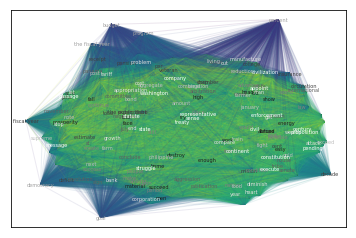

In [196]:
before_kmeans_cosine = ut.network_graph(before_cosine, 'kmeans', nounphrase, 'before', 'cosine')

### After 1914 Corpus

First turn the after dictionary into a co-occurrence matrix and create cosine and dissimilarity versions of it

In [203]:
after_occur = ut.convert_dict_to_list(after_dict)
co_after = ut.co_oc_matrix(after_occur, True, False)
after_cosine = ut.pairwise_similarity(co_after, 'cosine')
after_paper = ut.pairwise_similarity(co_after, 'paper')

In [204]:
after_paper.to_csv('after_regex.csv')
after_cosine.to_csv('after_cosine.csv')

Create network graph using community detection algorithm and paper dissimilarity

['mr', 'president', 'member', 'congress', 'honor', 'today', 'mark', 'union', 'address', 'old', 'republic', 'washington', 'begin', 'nation', 'preservation', 'liberty', 'finally', 'hand', 'the american people', 'friend', 'press', 'place', 'let', 'say', 'matter', 'ask', 'stand', 'together', 'aggression', 'speak', 'day', 'arm', 'make', 'country', 'serve', 'well', 'u', 'peace', 'purchase', 'price', 'strength', 'burden', 'freedom', 'visit', 'chamber', 'last year', 'believe', 'fail', 'propose', 'administration', 'state', 'america', 'could', 'achieve', 'prosperity', 'world', 'child', 'humanity', 'duty', 'report', 'tonight', 'progress', 'relation', 'other nation', 'foundation', 'lay', 'change', 'face', 'people', 'high', 'difference', 'line', 'million', 'harbor', 'safe', 'understand', 'must', 'look', 'go', 'situation', 'time', 'see', 'increase', 'inflation', 'soon', 'turn', 'government', 'money', 'supply', 'spending', 'last', 'month', 'example', 'percent', 'remain', 'interest', 'rate', 'reach', 

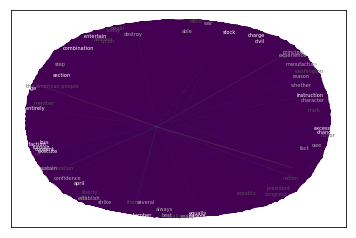

In [205]:
after_cda_paper = ut.network_graph(after_paper, 'community', nounphrase, 'after', 'paper')

Create network graph using community detection algorithm and cosine dissimilarity

['mr', 'member', 'high', 'soon', 'month', 'past', 'cut', 'nearly', 'half', 'run', 'six', 'since', 'growth', 'save', 'spend', 'four', 'pas', 'raise', 'deficit', 'less', 'hundred', 'three', 'th', 'education', 'receive', 'pay', 'house', 'senate', 'rule', 'complete', 'ship', 'extend', 'fair', 'contain', 'five', 'election', 'standard', 'insurance', 'living', 'afford', 'third', 'april', 'september']
['president', 'honor', 'today', 'mark', 'union', 'address', 'old', 'republic', 'washington', 'begin', 'nation', 'preservation', 'liberty', 'finally', 'hand', 'the american people', 'friend', 'place', 'let', 'say', 'matter', 'ask', 'stand', 'together', 'aggression', 'speak', 'day', 'arm', 'make', 'country', 'serve', 'well', 'u', 'peace', 'strength', 'burden', 'freedom', 'visit', 'chamber', 'last year', 'believe', 'fail', 'state', 'america', 'could', 'achieve', 'prosperity', 'world', 'child', 'humanity', 'tonight', 'progress', 'other nation', 'foundation', 'lay', 'change', 'face', 'people', 'differ

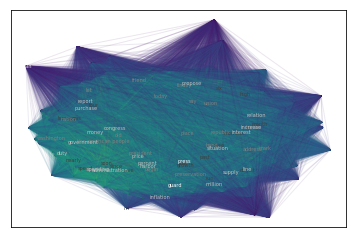

In [206]:
after_cda_cosine = ut.network_graph(after_cosine, 'community', nounphrase, 'after', 'cosine')

In [207]:
after_paper = pd.read_csv('after_regex.csv', index_col=0)

Create network graph using kmeans and paper dissimilarity

['mr', 'president', 'member', 'congress', 'honor', 'today', 'mark', 'union', 'address', 'old', 'republic', 'washington', 'begin', 'nation', 'preservation', 'liberty', 'finally', 'hand', 'the american people', 'friend', 'press', 'place', 'let', 'say', 'matter', 'ask', 'stand', 'together', 'aggression', 'speak', 'day', 'arm', 'make', 'country', 'serve', 'well', 'u', 'peace', 'purchase', 'price', 'strength', 'burden', 'freedom', 'visit', 'chamber', 'last year', 'believe', 'fail', 'propose', 'administration', 'state', 'america', 'could', 'achieve', 'prosperity', 'world', 'child', 'humanity', 'duty', 'report', 'tonight', 'progress', 'relation', 'other nation', 'foundation', 'lay', 'change', 'face', 'people', 'high', 'difference', 'line', 'million', 'harbor', 'safe', 'understand', 'look', 'go', 'situation', 'see', 'increase', 'inflation', 'soon', 'turn', 'government', 'money', 'supply', 'spending', 'last', 'month', 'example', 'percent', 'remain', 'interest', 'rate', 'reach', 'largely', 'cont

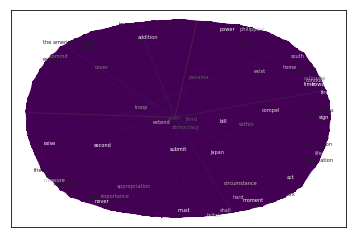

In [208]:
after_kmeans_paper = ut.network_graph(after_paper, 'kmeans', nounphrase, 'after', 'paper')

Create network graph using kmeans and cosine similarity

['congress', 'today', 'begin', 'nation', 'hand', 'place', 'matter', 'ask', 'make', 'country', 'well', 'burden', 'last year', 'believe', 'fail', 'state', 'could', 'prosperity', 'progress', 'change', 'face', 'people', 'difference', 'must', 'look', 'go', 'time', 'soon', 'turn', 'government', 'last', 'example', 'interest', 'reach', 'continue', 'already', 'call', 'nearly', 'first', 'economy', 'create', 'still', 'act', 'would', 'far', 'year', 'also', 'work', 'clear', 'bring', 'since', 'take', 'grow', 'power', 'return', 'come', 'help', 'save', 'effort', 'many', 'restore', 'new', 'one', 'way', 'upon', 'capacity', 'need', 'preserve', 'program', 'put', 'good', 'much', 'course', 'plan', 'base', 'business', 'maintain', 'responsibility', 'policy', 'give', 'office', 'another', 'point', 'require', 'law', 'show', 'less', 'important', 'control', 'mean', 'yet', 'encourage', 'without', 'find', 'seek', 'promise', 'provide', 'hope', 'think', 'realize', 'may', 'goal', 'protect', 'every', 'whose', 'nothing',

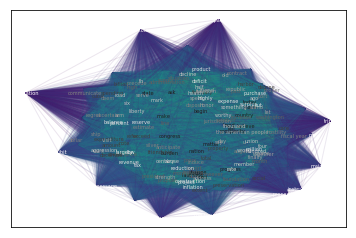

In [209]:
after_kmeans_cosine = ut.network_graph(after_cosine, 'kmeans', nounphrase, 'after', 'cosine')